In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


### Create dataset

In [84]:
X, Y = make_blobs(1500, 2, centers = 4, cluster_std = .9)

In [85]:
X.shape, Y.shape

((1500, 2), (1500,))

In [86]:
type(X)

numpy.ndarray

In [87]:
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.LongTensor)

In [88]:
Y

tensor([2, 0, 0,  ..., 3, 1, 0])

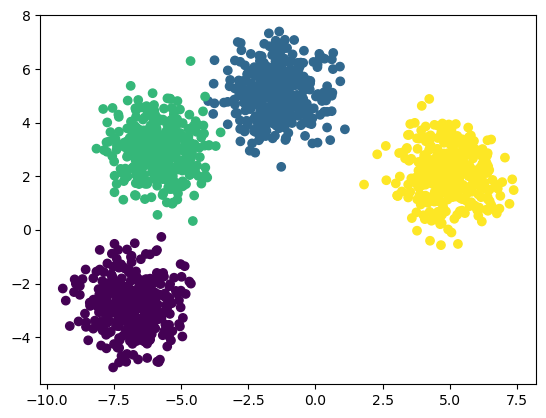

In [89]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=.25)

Text(0.5, 1.0, 'Test data')

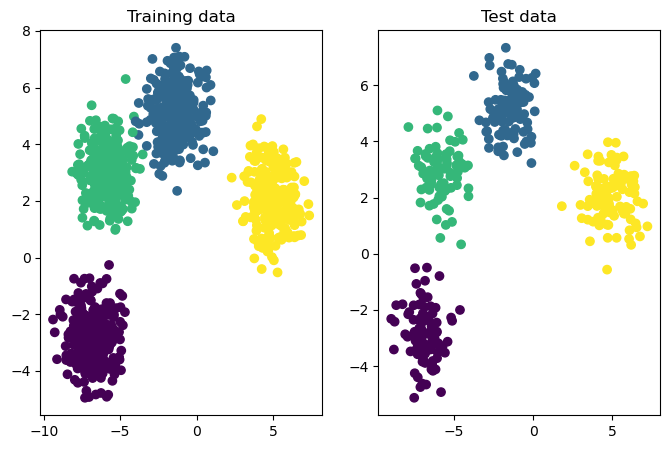

In [91]:
fig, axes = plt.subplots(1, 2, figsize = (8, 5))

axes[0].scatter(X_train[:, 0], X_train[:,1], c=Y_train)
axes[0].set_title("Training data")
axes[1].scatter(X_test[:, 0], X_test[:,1], c=Y_test)
axes[1].set_title("Test data")

### Build the model

In [92]:
class Multi_Class_Blobs_model(nn.Module):
    def __init__(self, input, out, hidden):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=out),
            nn.ReLU()
        )
    def forward(self, X):
        return self.linear_layer_stack(X)

model_1 = Multi_Class_Blobs_model(input=2, out=4, hidden=8).to(device)
model_1

Multi_Class_Blobs_model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
  )
)

In [93]:
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model_1.parameters(), lr=.01)

X_train, X_test, Y_train, Y_test = X_train.to(device), X_test.to(device), Y_train.to(device), Y_test.to(device)

In [94]:
model_1(X_train[:6])

tensor([[0.4085, 0.2157, 0.3035, 0.0000],
        [0.1781, 0.2266, 0.2456, 0.0000],
        [0.1546, 0.3311, 0.2220, 0.0000],
        [0.1626, 0.2955, 0.2301, 0.0000],
        [0.1749, 0.2407, 0.2424, 0.0000],
        [0.3770, 0.1940, 0.2969, 0.0000]], device='cuda:0',
       grad_fn=<ReluBackward0>)

In [95]:
# softmax is used here because we want mutually
# exclusive classes
pred = torch.softmax(model_1(X_train[:6]), dim=1)
torch.argmax(pred[5])

tensor(0, device='cuda:0')

In [96]:
epochs = 5000
train_loss = []
test_loss = []
epoch_list = []

for epoch in range(epochs):
    model_1.train()
    train_logit = model_1(X_train)
    # dim = 1 because we want the row wise application
    train_pred = torch.softmax(train_logit, dim=1).argmax(dim=1)
    tr_l = loss_func(train_logit, Y_train)

    optim.zero_grad()
    tr_l.backward()
    optim.step()

    model_1.eval()
    with torch.inference_mode():
        test_logit = model_1(X_test)
        test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)
        test_l = loss_func(test_logit, Y_test)
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {tr_l:.5f} | Test Loss: {test_l:.5f}")
        epoch_list.append(epoch)
        train_loss.append(tr_l.to("cpu").detach().numpy())
        test_loss.append(test_l.to("cpu").detach().numpy())

Epoch: 0 | Loss: 1.51564 | Test Loss: 1.52685
Epoch: 10 | Loss: 1.42961 | Test Loss: 1.43675
Epoch: 20 | Loss: 1.36584 | Test Loss: 1.36965
Epoch: 30 | Loss: 1.31542 | Test Loss: 1.31647
Epoch: 40 | Loss: 1.27585 | Test Loss: 1.27618
Epoch: 50 | Loss: 1.25054 | Test Loss: 1.25022
Epoch: 60 | Loss: 1.22771 | Test Loss: 1.22650
Epoch: 70 | Loss: 1.20530 | Test Loss: 1.20312
Epoch: 80 | Loss: 1.18262 | Test Loss: 1.17943
Epoch: 90 | Loss: 1.15947 | Test Loss: 1.15513
Epoch: 100 | Loss: 1.13608 | Test Loss: 1.13032
Epoch: 110 | Loss: 1.11217 | Test Loss: 1.10485
Epoch: 120 | Loss: 1.08794 | Test Loss: 1.07903
Epoch: 130 | Loss: 1.06361 | Test Loss: 1.05299
Epoch: 140 | Loss: 1.03940 | Test Loss: 1.02709
Epoch: 150 | Loss: 1.01556 | Test Loss: 1.00159
Epoch: 160 | Loss: 0.99244 | Test Loss: 0.97688
Epoch: 170 | Loss: 0.97033 | Test Loss: 0.95330
Epoch: 180 | Loss: 0.94942 | Test Loss: 0.93105
Epoch: 190 | Loss: 0.92982 | Test Loss: 0.91026
Epoch: 200 | Loss: 0.91152 | Test Loss: 0.89090
Epo

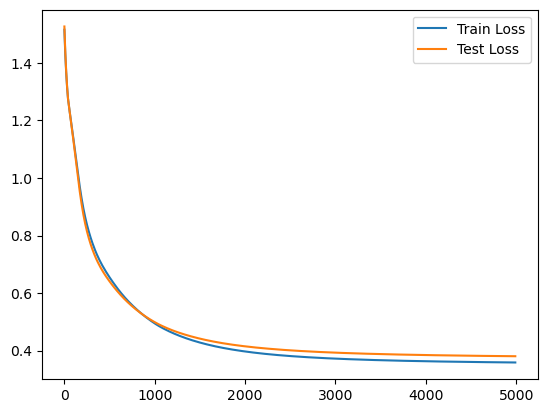

In [97]:
plt.plot(epoch_list, train_loss, label='Train Loss')
plt.plot(epoch_list, test_loss, label='Test Loss')
plt.legend()
plt.show()

There were sudden spikes, which means learning rate is too high!! So i reduced the learning rate and now its reducing smoothly

In [98]:
print(f"Predictions: {test_pred[:10]}\nLabels: {Y_test[:10]}")

Predictions: tensor([2, 0, 0, 1, 0, 0, 0, 0, 1, 2], device='cuda:0')
Labels: tensor([2, 0, 0, 1, 3, 0, 3, 0, 1, 2], device='cuda:0')
